In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/IPOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import cosima_cookbook as cc
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=28)         
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16,  0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### 1000 m isobath shelf mask

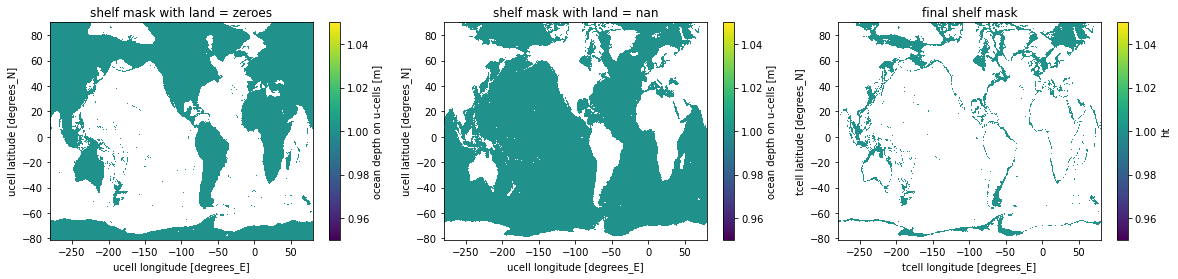

In [2]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
vars = ['ht', 'hu']
for f in range(2): # loop through the t- and u-grid
    field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').load()[vars[f]]
    above_1 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
                                             # the land here gets filled in with zeros as well
    above_1 = above_1.where(above_1 < 1000, drop=False) # remove all values bigger than 1000

    above_2 = field.where((field <= 1000) | field.isnull(), 0) # select only the shelf region and set all other values to zero
    above_2 = above_2.where(np.logical_or(above_2.isnull(), xr==0), 1) # replace all non-nan with 1 while keeping the land as nan
    above1000 = (above_1*above_2)

    if f == 0: above1000_tcells = above1000
    if f == 1: above1000_ucells = above1000
plt.figure(figsize=(20,4))
plt.subplot(1,3,1); above_1.plot(); plt.title('shelf mask with land = zeroes')
plt.subplot(1,3,2); above_2.plot(); plt.title('shelf mask with land = nan')
plt.subplot(1,3,3); above1000_tcells.plot(); plt.title('final shelf mask')
# above1000_tcells.to_netcdf('/g/data/e14/mv7494/IPOAnt_analysis/ACCESS-OM2-01_1000dbar_shelf_mask.nc')
b = field.fillna(0)

### Loading in wind stress from the last cycle of the ACCESS-OM2-01 simulation

In [3]:
%%time
import cosima_cookbook as cc
session = cc.database.create_session()
# ---------------------------------------------------------------------------------- #
sel_lat     = [   0,  239]  # 81.1°S - 59.5°S                                         #
sel_lon     = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                             #
Weddell_lat = [   0,  270]  # Wedell Sea only                                         #
#Weddell_lon = [2099, 2999] # Wedell Sea only                                          #
#Ross_lon    = [ 599, 1200] # Wedell Sea only                                          #
Weddell_lon = [2169, 2300] # 63°W - 50°W, only the western part of the Weddell         #
Ross_lon    = [ 799, 920] # 160°E to 172°E or -200°E to -188°E
depth       = [  23,   75]  # 100 m to 1000 m                                         #
# ---------------------------------------------------------------------------------- #
for f in range(2):
    if f == 0: region_lons = Weddell_lon
    if f == 1: region_lons = Ross_lon
    tau_y = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='tau_y', 
                                        session=session, frequency='1 monthly',
                                        attrs={'cell_methods': 'time: mean'},
                                        chunks = {'yu_ocean': '200MB', 'xu_ocean': '200MB'})[:,sel_lat[0]:sel_lat[1],region_lons[0]:region_lons[1]]
    tau_y = (tau_y * above1000_ucells[:263,:]).mean(['yu_ocean', 'xu_ocean']) # mask out the shelf area

    if f == 0: 
        tau_y_Weddell     = tau_y.groupby('time.month') - tau_y[:12*30].groupby('time.month').mean('time') # subtract the climatology over 1958-1988
        tau_y_Weddell_IAF = tau_y_Weddell[tau_y_Weddell.time.dt.month.isin([6,7,8])]
    if f == 1: 
        tau_y_Ross        = tau_y.groupby('time.month') - tau_y[:12*30].groupby('time.month').mean('time')
        tau_y_Ross_IAF    = tau_y_Ross[tau_y_Ross.time.dt.month.isin([6,7,8])]
# Wall time: 10.7 s

CPU times: user 3.84 s, sys: 612 ms, total: 4.45 s
Wall time: 6.24 s


### ... and now also the wind stress anomalies from the IPOInt simulation

In [4]:
%%time
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt',
              '01deg_jra55_ryf_IPO2sNeg']
session = cc.database.create_session('local_cc_scratch_2sigma.db')
for e in [3,4]:
    print(exp[e])
    for f in range(2):
        if f == 0: region_lons = Weddell_lon
        if f == 1: region_lons = Ross_lon
        tau_y_clim = cc.querying.getvar(expt=exp[0], variable='tau_y', 
                                            session=session, frequency='1 monthly',
                                            attrs={'cell_methods': 'time: mean'},
                                            chunks = {'yu_ocean': '200MB', 'xu_ocean': '200MB'})[:,sel_lat[0]:sel_lat[1],region_lons[0]:region_lons[1]]
        tau_y = cc.querying.getvar(expt=exp[e], variable='tau_y', 
                                            session=session, frequency='1 monthly',
                                            attrs={'cell_methods': 'time: mean'},
                                            chunks = {'yu_ocean': '200MB', 'xu_ocean': '200MB'})[:,sel_lat[0]:sel_lat[1],region_lons[0]:region_lons[1]]
        tau_y = ((tau_y - tau_y_clim)* above1000_ucells[:263,:]).mean(['yu_ocean', 'xu_ocean']) # mask out the shelf area
    
        if f == 0: 
            tau_y_Weddell = tau_y[tau_y.time.dt.month.isin([6,7,8])] # select only winter
        if f == 1: 
            tau_y_Ross    = tau_y[tau_y.time.dt.month.isin([6,7,8])]
    if e == 3: tau_y_Weddell_IPOInt   = tau_y_Weddell; tau_y_Ross_IPOInt   = tau_y_Ross
    if e == 4: tau_y_Weddell_IPO2sNeg = tau_y_Weddell; tau_y_Ross_IPO2sNeg = tau_y_Ross
# Wall time: 8.11 s
# xr.open_mfdataset('/g/data/e14/rmh561/access-om2/archive/025deg_era5_iaf_1958cycle1/' + 'output*/ocean/ocean_month.nc').tau_y[]

01deg_jra55_ryf_IPOInt


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22466595903296 and this is thread id 22463676159744.
Exception closing connection <sqlite3.Connection object at 0x146df868dd50>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/b

01deg_jra55_ryf_IPO2sNeg
CPU times: user 5.23 s, sys: 1.05 s, total: 6.28 s
Wall time: 13.5 s


CPU times: user 4.06 s, sys: 523 ms, total: 4.58 s
Wall time: 5.11 s


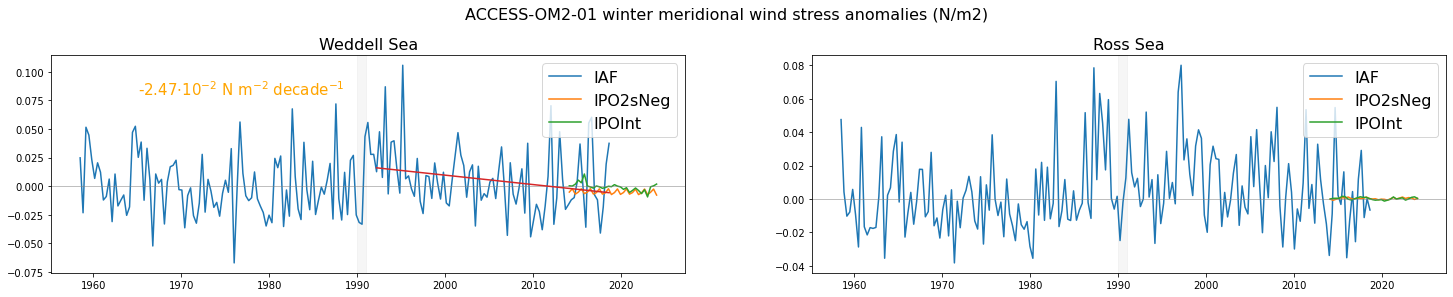

In [5]:
%%time
plt.figure(figsize=(25,4))
plt.suptitle('ACCESS-OM2-01 winter meridional wind stress anomalies (N/m2)', fontsize=16, y=1.05)

plt.subplot(1,2,1); plt.title('Weddell Sea', fontsize=16)
time        = np.linspace(1958.5,  2018.6,   len(tau_y_Weddell_IAF))
time_IPOInt = np.linspace(2014.08, 2023.999, len(tau_y_Weddell_IPOInt))
# -------------------------------------------------------------------------------------------------------------- #
plt.plot(time,        tau_y_Weddell_IAF, label='IAF') #.rolling(time=3, center=True).mean()
plt.plot(time_IPOInt, tau_y_Weddell_IPO2sNeg, label = 'IPO2sNeg')
plt.plot(time_IPOInt, tau_y_Weddell_IPOInt, label = 'IPOInt')
# -------------------------------------------------------------------------------------------------------------- #

plt.axhline(0, lw=.5, color='grey')
plt.legend(fontsize=16)
plt.axvspan(1990, 1991, color=[.83, .83, .83], alpha=.2) # shading the RYF period 1990-91

from scipy import stats
z = np.polyfit(time[102:], tau_y_Weddell_IAF[102:].values, 1); poly1 = np.poly1d(z) 
plt.plot(time[102:], poly1(time[102:]))
# trend value 
plt.text(time[20], .08, str(np.round(1e2*poly1[1]*3*10,2)) + r'$\cdot$10$^{-2}$ N m$^{-2}$ decade$^{-1}$', fontsize=15, horizontalalignment = 'left', color = 'orange')

plt.subplot(1,2,2); plt.title('Ross Sea', fontsize=16)
# -------------------------------------------------------------------------------------------------------------- #
plt.plot(time, tau_y_Ross_IAF, label='IAF') #.rolling(time=3, center=True).mean()
plt.plot(time_IPOInt, tau_y_Ross_IPO2sNeg, label = 'IPO2sNeg')
plt.plot(time_IPOInt, tau_y_Ross_IPOInt, label = 'IPOInt')
# -------------------------------------------------------------------------------------------------------------- #

plt.axhline(0, lw=.5, color='grey')
plt.legend(fontsize=16)
plt.axvspan(1990, 1991, color=[.83, .83, .83], alpha=.2) # shading the RYF period 1990-91
# Wall time: 11.2 s

### Same figure but with the wind speed instead of windstress

In [25]:
%%time
# ---------------------------------------------------------------------------------- #
Weddell_lat = [ 20,   35] # 78°S to 70°S, only the western part of the Weddell Sea   #
Weddell_lon = [528,  552] # 297°E to 310°E, only the western part of the Weddell Sea #
Ross_lat    = [ 20,   35] # 160°E to 172°E or -200°E to -188°E
Ross_lon    = [ 285, 307] # 160°E to 172°E or -200°E to -188°E
depth       = [  23,   75]  # 100 m to 1000 m                                         #
region      = ['Weddell Sea', 'Ross Sea'] 
# ---------------------------------------------------------------------------------- #
for f in range(2):
    if f == 0: region_lats = Weddell_lat; region_lons = Weddell_lon
    if f == 1: region_lats = Ross_lat;    region_lons = Ross_lon
    print('Doing analysis for ' + region[f])
    vas = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hrPt/vas/gn/v20180412/' + 
                            'vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_*.nc').vas[:,region_lats[0]:region_lats[1],region_lons[0]:region_lons[1]]
    # resample first to take monthly mean, then create anomaly by removing the 1981-2010 climatological period
    anom = vas.resample(time="1MS").mean(dim="time").groupby('time.month') - vas.resample(time="1MS").mean(dim="time")[276:276+12*30,:,:].groupby('time.month').mean('time') # select 1981-2010 climatology
    anom = anom.mean(['lat', 'lon'])
    
    if f == 0: vas_Weddell_JRA = anom[anom.time.dt.month.isin([6,7,8])] # select only winter
    if f == 1: vas_Ross_JRA    = anom[anom.time.dt.month.isin([6,7,8])]

Doing analysis for Weddell Sea
Doing analysis for Ross Sea
CPU times: user 8.28 s, sys: 439 ms, total: 8.72 s
Wall time: 8.3 s


### and now the wind speed as used in IPOPos, IPONeg, IPO2sNeg

In [42]:
%%time
ordner        = ['IPOCtrl', 'positive_phase_fields','negative_phase_fields', 'IPOInt','2sigma_negative_phase_fields']

for e in [1,2,4]:
    for f in range(2):
        if f == 0: region_lats = Weddell_lat; region_lons = Weddell_lon
        if f == 1: region_lats = Ross_lat;    region_lons = Ross_lon
        print('Doing analysis for ' + region[f])
        vas_clim = xr.open_mfdataset('/g/data/ua8/JRA55-do/RYF/v1-3/' + 'RYF.v_10.1990_1991.nc').vas_10m[:,region_lats[0]:region_lats[1],region_lons[0]:region_lons[1]]
        vas_exp  = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/' + ordner[e] + '/RYF.vas_10m.1990_1991.nc').vas_10m[:,region_lats[0]:region_lats[1],region_lons[0]:region_lons[1]]
        vas_anom = (vas_exp - vas_clim) # take anomalies

        vas_anom = vas_anom.mean(['time', 'latitude', 'longitude']) # take mean over time, lat and lon...I can do this because my anomalous forcing is constant in time

        # save variables
        if e == 1 and f == 0: vas_anom_IPOPos_Weddell     = vas_anom.load()
        if e == 1 and f == 1: vas_anom_IPOPos_Ross        = vas_anom.load()
        if e == 2 and f == 0: vas_anom_IPONeg_Weddell     = vas_anom.load()
        if e == 2 and f == 1: vas_anom_IPONeg_Ross        = vas_anom.load()
        if e == 4 and f == 0: vas_anom_IPO2sNeg_Weddell   = vas_anom.load()
        if e == 4 and f == 1: vas_anom_IPO2sNeg_Ross      = vas_anom.load()    

Doing analysis for Weddell Sea
Doing analysis for Ross Sea
Doing analysis for Weddell Sea
Doing analysis for Ross Sea
Doing analysis for Weddell Sea
Doing analysis for Ross Sea
CPU times: user 10.4 s, sys: 2.94 s, total: 13.4 s
Wall time: 1min


### ...and the wind speed values from ERA5

In [39]:
%%time
# ---------------------------------------------------------------------------------- #
Weddell_lat = [ 44,    73] # 78°S to 70°S, only the western part of the Weddell Sea   #
Weddell_lon = [468,   521] # 297°E to 310°E, only the western part of the Weddell Sea #
Ross_lat    = [ 44,    73] # 160°E to 172°E or -200°E to -188°E
Ross_lon    = [ 1360, 1409] # 160°E to 172°E or -200°E to -188°E
depth       = [  23,   75]  # 100 m to 1000 m                                         #
region      = ['Weddell Sea', 'Ross Sea'] 
# ---------------------------------------------------------------------------------- #
for f in range(2):
    if f == 0: region_lats = Weddell_lat; region_lons = Weddell_lon
    if f == 1: region_lats = Ross_lat;    region_lons = Ross_lon
    print('Doing analysis for ' + region[f])
    anom = xr.open_dataset('/g/data/e14/mv7494/ERA5/v/' + 'ERA5_Antarctic_v_monthly_anomalies_1959-2023.nc').v_day_anom[:,region_lats[0]:region_lats[1],region_lons[0]:region_lons[1]]
    anom = anom.mean(['latitude', 'longitude'])
    if f == 0: vas_Weddell_ERA5 = anom[anom.time.dt.month.isin([6,7,8])].load() # select only winter
    if f == 1: vas_Ross_ERA5    = anom[anom.time.dt.month.isin([6,7,8])].load()
# 15min 31s

Doing analysis for Weddell Sea
Doing analysis for Ross Sea
CPU times: user 58.5 ms, sys: 95 ms, total: 154 ms
Wall time: 139 ms


CPU times: user 4.96 s, sys: 1.33 s, total: 6.29 s
Wall time: 28.5 s


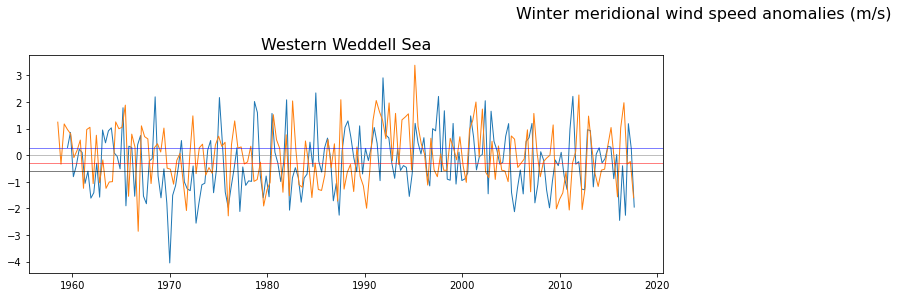

In [43]:
%%time
plt.figure(figsize=(25,4))
plt.suptitle('Winter meridional wind speed anomalies (m/s)', fontsize=16, y=1.05)

# first subplot
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
plt.subplot(1,2,1); plt.title('Western Weddell Sea', fontsize=16)
time_ERA        = np.linspace(1959.5,  2017.666,   len(vas_Weddell_ERA5))
time_JRA        = np.linspace(1958.5,  2017.6,   len(vas_Weddell_JRA))
# -------------------------------------------------------------------------------------------------------------- #
plt.plot(time_ERA,        vas_Weddell_ERA5, label='ERA5', lw=1) #.rolling(time=3, center=True).mean()
plt.plot(time_JRA,        vas_Weddell_JRA, label='JRA', lw=1) #.rolling(time=3, center=True).mean()
#plt.plot(time_IPOInt, vas_Weddell_IPO2sNeg, label = 'IPO2sNeg')
#plt.plot(time_IPOInt, vas_Weddell_IPOInt, label = 'IPOInt')
# -------------------------------------------------------------------------------------------------------------- #

plt.axhline(0, lw=.5, color='grey')

plt.axhline(vas_anom_IPOPos_Weddell, lw=.5, color='blue')
plt.axhline(vas_anom_IPONeg_Weddell, lw=.5, color='red')
plt.axhline(vas_anom_IPO2sNeg_Weddell, lw=.5, color='k') # replace with markers tomorrow

CPU times: user 14.7 s, sys: 3.87 s, total: 18.6 s
Wall time: 1min 21s


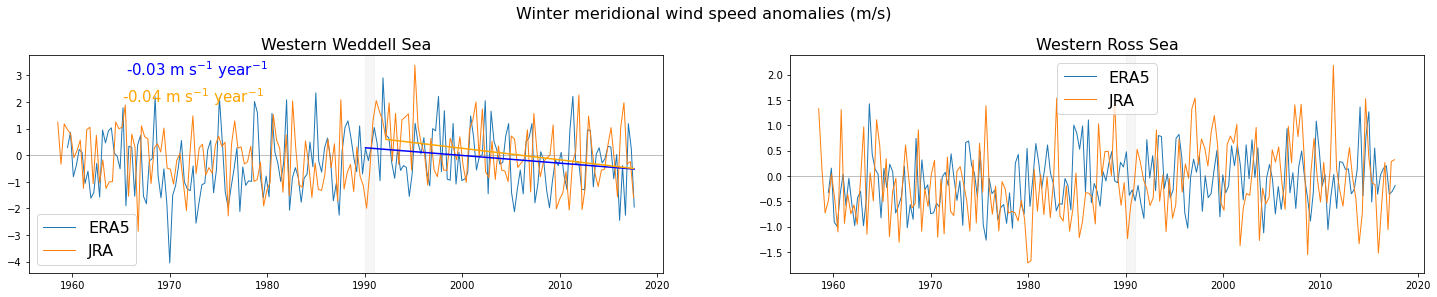

In [ ]:
plt.legend(fontsize=16)
plt.axvspan(1990, 1991, color=[.83, .83, .83], alpha=.2) # shading the RYF period 1990-91

from scipy import stats
z = np.polyfit(time_ERA[102:], vas_Weddell_ERA5[102:].values, 1); poly1 = np.poly1d(z) 
plt.plot(time_ERA[102:], poly1(time_ERA[102:]), label='Trend ERA5', c='b')
# trend value 
plt.text(time_ERA[20], 3, str(np.round(poly1[1],2)) + r' m s$^{-1}$ year$^{-1}$', 
         fontsize=15, horizontalalignment = 'left', color = 'b') # trend value

z = np.polyfit(time_JRA[102:], vas_Weddell_JRA[102:].values, 1); poly1 = np.poly1d(z) 
plt.plot(time_JRA[102:], poly1(time_JRA[102:]), label='Trend JRA', c='orange')
plt.text(time_JRA[20], 2, str(np.round(poly1[1],2)) + r' m s$^{-1}$ year$^{-1}$', 
         fontsize=15, horizontalalignment = 'left', color = 'orange') # trend value

# second subplot
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
plt.subplot(1,2,2); plt.title('Western Ross Sea', fontsize=16)
# -------------------------------------------------------------------------------------------------------------- #
plt.plot(time_ERA, vas_Ross_ERA5, label='ERA5', lw=1) #.rolling(time=3, center=True).mean()
plt.plot(time_JRA, vas_Ross_JRA, label='JRA', lw=1) #.rolling(time=3, center=True).mean()
#plt.plot(time_IPOInt, vas_Ross_IPO2sNeg, label = 'IPO2sNeg')
#plt.plot(time_IPOInt, vas_Ross_IPOInt, label = 'IPOInt')
# -------------------------------------------------------------------------------------------------------------- #

plt.axhline(0, lw=.5, color='grey')
plt.legend(fontsize=16)
plt.axvspan(1990, 1991, color=[.83, .83, .83], alpha=.2) # shading the RYF period 1990-91
# Wall time: 1min 37s

In [ ]:
%%time
import glob
# Get a list of all .nc files available in different folders
filenames = glob.glob('/g/data/rt52/era5/single-levels/reanalysis/10v/*/*.nc')

# ---------------------------------------------------------------------------------- #
Weddell_lat = [ 48,    76] # 78°S to 70°S, only the western part of the Weddell Sea   #
Weddell_lon = [468,   521] # 297°E to 310°E, only the western part of the Weddell Sea #
Ross_lat    = [ 48,    76] # 160°E to 172°E or -200°E to -188°E
Ross_lon    = [ 1360, 409] # 160°E to 172°E or -200°E to -188°E
depth       = [  23,   75]  # 100 m to 1000 m                                         #
region      = ['Weddell Sea', 'Ross Sea'] 
# ---------------------------------------------------------------------------------- #
for f in range(2):
    if f == 0: region_lats = Weddell_lat; region_lons = Weddell_lon
    if f == 1: region_lats = Ross_lat;    region_lons = Ross_lon
    print('Doing analysis for ' + region[f])
    v10 = xr.open_mfdataset(filenames).v10.resample(time="1MS").mean(dim="time")
    # select 1981-2010 climatology and subtract it from the data to get the anomalies
    anom = v10.resample(time="1MS").mean(dim="time").groupby('time.month') - v10[492:492+12*30].groupby('time.month').mean('time') 
    anom = anom.mean(['latitude', 'longitude'])
    
    if f == 0: vas_Weddell_IAF_ERA5 = anom[anom.time.dt.month.isin([6,7,8])].load() # select only winter
    if f == 1: vas_Ross_IAF_ERA5    = anom[anom.time.dt.month.isin([6,7,8])].load()
# 15min 31s

### next steps: 
- add data from ERA5
- add data from IPO2sNeg (as a marker)
- add data from IPOInt